In [2]:
# Magic line to avoid explicitely write plt.show()
%matplotlib inline

In [3]:
#do not show warnings
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis (EDA)
This notebook will detail an exploratory data analysis of the sales dataset which will feed the forecasting model:
- As well, this will provide a quick way to check the generated/simulated data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
sales_clusters_df=pd.read_csv('../data/raw/sales_cluster_table.csv')

In [6]:
sales_clusters_df.Cluster.value_counts()

3    148
4     78
0     32
1     17
2      4
Name: Cluster, dtype: int64

In [7]:
sales_clusters_df.head()

product_code  noisy_date  noisy_quantity  Cluster
0         CLA0  2017-12-28     5038.619159        0
1         CLA0  2018-03-11     4658.195181        0
2         CLA0  2018-05-18     4676.433462        0
3         CLA0  2018-07-25     5067.550234        0
4         CLA0  2018-10-04     4602.628398        0

In [8]:
sales_clusters_df['noisy_date']=pd.to_datetime(sales_clusters_df['noisy_date'])

In [9]:
sales_clusters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 4 columns):
product_code      279 non-null object
noisy_date        279 non-null datetime64[ns]
noisy_quantity    279 non-null float64
Cluster           279 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.8+ KB


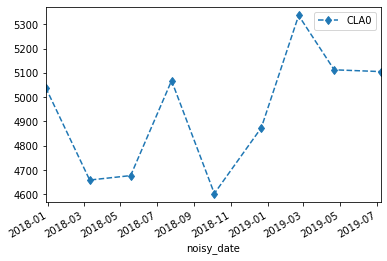

In [10]:
sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date','noisy_quantity']]\
.plot.line(x='noisy_date',y='noisy_quantity',linestyle='--',marker='d')
plt.legend(['CLA0'])

# Just a small prophet model to try the library

- I then realise we need to build a model to predict the next sale date and then the next sale quantity

In [11]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
import plotly.graph_objs as go

## First model to predict next sale date

In [12]:
train_year='2018'
test_year='2019'

In [13]:
def generate_next_sale_column(df):
    df['next_sale_date']=df['noisy_date'].shift(-1)
    df.drop([len(df)-1],inplace=True)
    
    # y will be the number of days until the next sale
    df['y']=(df['next_sale_date']-df['noisy_date']).dt.days.astype(int)
    
    return df

In [14]:
def plot_date_preds(date_forecast,product,idx_split):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=date_forecast['ds'],
                             y=date_forecast['actual_y'],
                              marker=dict(
                                        color='LightSkyBlue',
                                        size=20,
                                        line=dict(
                                            color='black',
                                            width=2
                                        )
                                    ),
                                mode='markers',
                            name='actual_y'))

    fig.add_trace(go.Scatter(x=date_forecast['ds'][idx_split-1:],
                             y=date_forecast['yhat'][idx_split-1:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=15,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat'))


    fig.add_trace(go.Scatter(x=date_forecast['ds'][idx_split-1:],
                             y=date_forecast['yhat_lower'][idx_split-1:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=10,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat_lower'))

    fig.add_trace(go.Scatter(x=date_forecast['ds'][idx_split-1:],
                             y=date_forecast['yhat_upper'][idx_split-1:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=10,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat_upper'))

    fig.update_layout(
        shapes=[
            # Line Vertical
            go.layout.Shape(
                type="line",
                x0=date_forecast['ds'][idx_split-2],
                y0=np.min(date_forecast['actual_y']),
                x1=date_forecast['ds'][idx_split-2],
                y1=np.max(date_forecast['actual_y']),
                line=dict(
                    color="grey",
                    width=2,
                    dash="dashdot"
                )
            )
        ]
    )

    fig.add_trace(go.Scatter(
        x=[date_forecast['ds'][idx_split-3],
          date_forecast['ds'][idx_split-1]],
        y=[np.mean(date_forecast['actual_y']),
                   np.mean(date_forecast['actual_y'])],
        text=["Training data <--",
              "--> Testing data"],
        mode="text",
        name='training and test data'
    ))

    # Edit the layout
    fig.update_layout(title='Next sales dates for ' + product,
                       xaxis_title='Date',
                       yaxis_title='Number of days until next sale')



    fig.show()
    
    return

In [15]:
def plot_full_preds(full_preds_df, product, idx_split):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=full_preds_df['ds'],
                             y=full_preds_df['y'],
                              marker=dict(
                                        color='LightSkyBlue',
                                        size=20,
                                        line=dict(
                                            color='black',
                                            width=2
                                        )
                                    ),
                                mode='markers',
                            name='actual_y'))

    fig.add_trace(go.Scatter(x=full_preds_df['yhat_date'][idx_split:],
                             y=full_preds_df['yhat_qty'][idx_split:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=15,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat'))


    fig.add_trace(go.Scatter(x=full_preds_df['yhat_lower_date'][idx_split:],
                             y=full_preds_df['yhat_lower_qty'][idx_split:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=10,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat_lower'))

    fig.add_trace(go.Scatter(x=full_preds_df['yhat_upper_date'][idx_split:],
                             y=full_preds_df['yhat_upper_qty'][idx_split:].astype(int),
                             opacity=0.5,
                             marker=dict(
                                        size=10,
                                        line=dict(
                                            color='MediumPurple',
                                            width=2
                                        )
                                    ),
                            mode='markers',
                            name='yhat_upper'))

    fig.update_layout(
        shapes=[
            # Line Vertical
            go.layout.Shape(
                type="line",
                x0=full_preds_df['ds'][idx_split-1],
                y0=np.min(full_preds_df['y']),
                x1=full_preds_df['ds'][idx_split-1],
                y1=np.max(full_preds_df['y']),
                line=dict(
                    color="grey",
                    width=2,
                    dash="dashdot"
                )
            )
        ]
    )

    fig.add_trace(go.Scatter(
        x=[full_preds_df['ds'][idx_split-2],
          full_preds_df['ds'][idx_split]],
        y=[np.mean(full_preds_df['y']),
                   np.mean(full_preds_df['y'])],
        text=["Training data <--",
              "--> Testing data"],
        mode="text",
        name='training and test data'
    ))

    # Edit the layout
    fig.update_layout(title='Predicted dates and quantities for ' + product,
                       xaxis_title='Date',
                       yaxis_title='Sales quantities')



    fig.show()
    
    return

In [16]:
def print_msg(msg):
    length=len(msg)
    print(length*'-'+'\n'+msg+'\n'+length*'-')
    return

In [17]:
def generate_models_n_preds_df_n_plotly_viz(product):
    """ This function aims to take a product and output:
        -  1 date model
        -  1 qty model
        -  1 predictions df
        -  1 plotly graph of the predictions
    """
    
    # First select the product df with the sales dates and copy it into a new df
    prophet_date_df=sales_clusters_df[sales_clusters_df.product_code==product][['noisy_date']].copy()
    prophet_date_df.reset_index(drop=True,inplace=True)
    
    # Using global variable "test_year", generate the index where we split the df into a train year and a test year
    idx_split=prophet_date_df['noisy_date'][(prophet_date_df['noisy_date']>=test_year).cumsum()==1].index[0]
    
    # Generate the next sale date column which will be necessary to generate the "number of days to next sale" feature
    # This is the feature the "date model" will have to predict
    prophet_date_df=generate_next_sale_column(prophet_date_df)
    
    # Refactor the column names for the Facebook Prophet library
    prophet_date_df.rename(index=str, columns={"noisy_date": "ds"},
                 inplace=True)
    
    # Create the "date model"
    next_sale_date_model=Prophet()
    
    # Train the model on the training year
    print_msg('--> Now training the "date model"')
    next_sale_date_model.fit(prophet_date_df[:idx_split-1])
    
    # Make predictions on the complete df (training + test year) : this will let us check the overfitting later on
    next_sale_date_forecast = next_sale_date_model.predict(pd.DataFrame(prophet_date_df['ds']))
    
    # This is if you want to plot the date plot
    #plot_date_preds(next_sale_date_forecast,product,idx_split)
    
    # Select the product df with the sales dates AND quantities and copy it into a new df
    prophet_qty_df=sales_clusters_df[sales_clusters_df.product_code==product][['noisy_date','noisy_quantity']].copy()
    
    # Make it prophet compliant
    prophet_qty_df.rename(index=str, 
                          columns={"noisy_date": "ds",
                                      "noisy_quantity": "y"},
                         inplace=True)
    
    # Instantiate the quantity model 
    qty_model=Prophet()
    
    print_msg('--> Now training the "quantity model"')
    qty_model.fit(prophet_qty_df[:idx_split])
    
    # Make predictions on the complete df (training + test year) : this will let us check the overfitting later on
    qty_forecast = qty_model.predict(pd.DataFrame(prophet_qty_df['ds']))
    
    # Select the interesting columns for the qty df
    qty_predictions=qty_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Renaming the prophet output columns to identify the quantity predictions (in comparison with the sales dates preds)
    for col in qty_predictions.columns[1:]:
        qty_predictions.rename(index=str,
                                columns={col: col+'_qty'},
                                inplace=True)
    
    # Select the interesting columns for the sales df  
    next_sale_dates_predictions=next_sale_date_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Make the sales df readable and easy to identify
    for col in next_sale_dates_predictions.columns[1:]:
        next_sale_dates_predictions[col]=[pd.Timedelta(str(int(t))+' days') for t in next_sale_dates_predictions[col].values]
        next_sale_dates_predictions[col]=next_sale_dates_predictions['ds']+next_sale_dates_predictions[col]
        next_sale_dates_predictions.rename(index=str,
                                            columns={col: col+'_date'},
                                            inplace=True)
    
    # Prepare the full_preds df which will include dates, quuantities predictions and the actual values 
    #(dates and quantities)    
    full_predictions_df=qty_predictions.copy()
    # Sales dates and quantities concatenation
    for col in next_sale_dates_predictions.columns[1:]:
        local_list=next_sale_dates_predictions[col].values.tolist()
        local_list.insert(0,np.nan)
        full_predictions_df[col]=pd.to_datetime(local_list)
    
    # Include the actual values in the full_preds_df
    full_predictions_df['y']=prophet_qty_df['y'].values
    
    # Plot it (fancy with plotly)
    plot_full_preds(full_predictions_df,
                  product,
                  idx_split)
    
    return (next_sale_date_model,
            qty_model,
            full_predictions_df)

In [18]:
help(generate_models_n_preds_df_n_plotly_viz)

Help on function generate_models_n_preds_df_n_plotly_viz in module __main__:

generate_models_n_preds_df_n_plotly_viz(product)
    This function aims to take a product and output:
    -  1 date model
    -  1 qty model
    -  1 predictions df
    -  1 plotly graph of the predictions



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


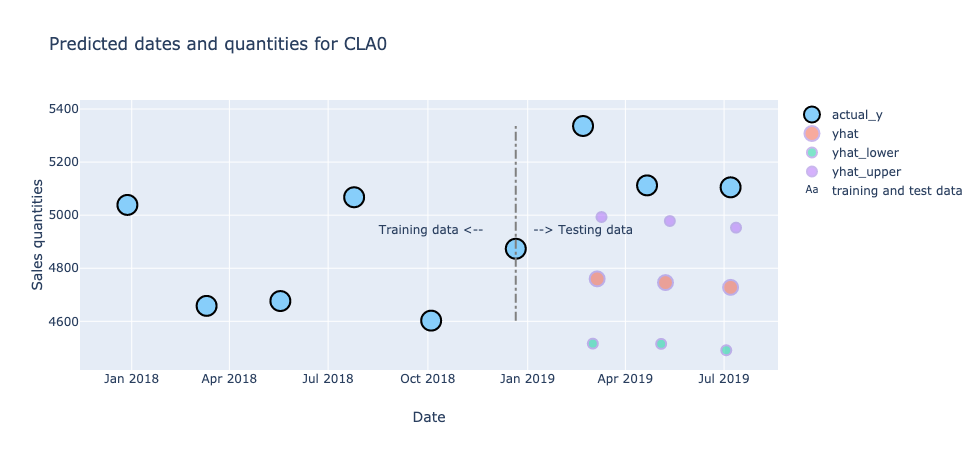

In [19]:
(next_sale_dt_mdl,qty_mdl,full_preds_df)=generate_models_n_preds_df_n_plotly_viz('CLA0')

In [20]:
full_preds_df

ds     yhat_qty  yhat_lower_qty  yhat_upper_qty  yhat_date  \
0 2017-12-28  4861.637512     4612.575597     5093.960764        NaT   
1 2018-03-11  4844.114412     4615.224710     5075.770829 2018-03-06   
2 2018-05-18  4827.791540     4624.135988     5093.334705 2018-05-20   
3 2018-07-25  4811.468679     4590.039700     5045.266829 2018-07-28   
4 2018-10-04  4794.425700     4562.714244     5018.835565 2018-10-05   
5 2018-12-21  4775.702427     4544.115565     5005.815964 2018-12-17   
6 2019-02-21  4760.819826     4516.516863     4993.558045 2019-03-06   
7 2019-04-21  4746.657350     4515.749734     4978.499236 2019-05-08   
8 2019-07-07  4728.174120     4491.236793     4953.192978 2019-07-07   

  yhat_lower_date yhat_upper_date            y  
0             NaT             NaT  5038.619159  
1      2018-03-02      2018-03-11  4658.195181  
2      2018-05-16      2018-05-24  4676.433462  
3      2018-07-24      2018-08-01  5067.550234  
4      2018-10-01      2018-10-09  4602.628398  
5      2018-12-12      2018-12-21  4873.462946  
6      2019-03-02      2019-03-10  5336.037630  
7      2019-05-04      2019-05-12  5112.239650  
8      2019-07-03      2019-07-12  5104.938014

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 0.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


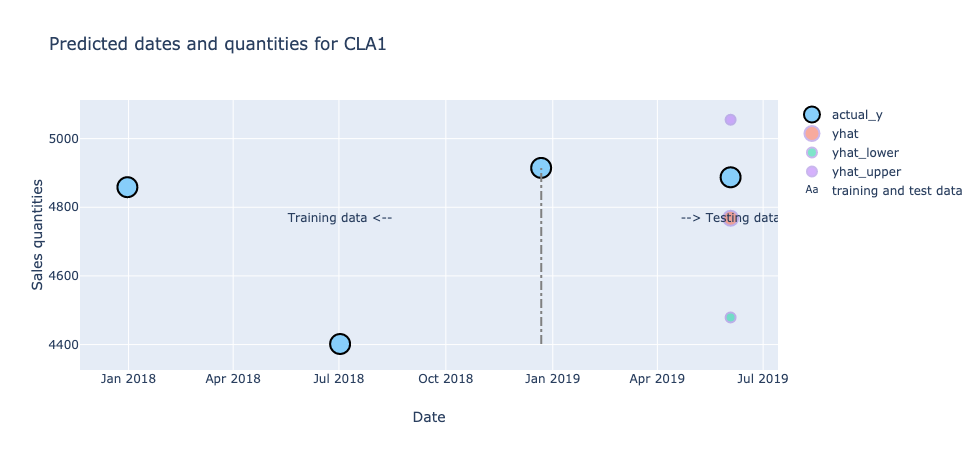

In [21]:
(next_sale_dt_mdl,qty_mdl,full_preds_df)=generate_models_n_preds_df_n_plotly_viz('CLA1')

In [22]:
full_preds_df

ds     yhat_qty  yhat_lower_qty  yhat_upper_qty  yhat_date  \
0 2017-12-31  4700.041748     4432.418598     4990.240728        NaT   
1 2018-07-02  4724.247626     4454.754138     5039.223127 2018-07-02   
2 2018-12-22  4747.130778     4452.227504     5015.177132 2018-12-22   
3 2019-06-03  4768.691205     4479.284938     5055.662080 2019-06-03   

  yhat_lower_date yhat_upper_date            y  
0             NaT             NaT  4858.555134  
1      2018-07-02      2018-07-02  4401.677868  
2      2018-12-22      2018-12-22  4914.696562  
3      2019-06-03      2019-06-03  4887.345789

# Clusters analysis : aggregation of products models

In [23]:
import plotly.graph_objects as go

In [24]:
sales_clusters_df.head()

product_code noisy_date  noisy_quantity  Cluster
0         CLA0 2017-12-28     5038.619159        0
1         CLA0 2018-03-11     4658.195181        0
2         CLA0 2018-05-18     4676.433462        0
3         CLA0 2018-07-25     5067.550234        0
4         CLA0 2018-10-04     4602.628398        0

In [25]:
sales_clusters_df[sales_clusters_df['Cluster']==0][['noisy_date','noisy_quantity']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 273
Data columns (total 2 columns):
noisy_date        32 non-null datetime64[ns]
noisy_quantity    32 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 768.0 bytes


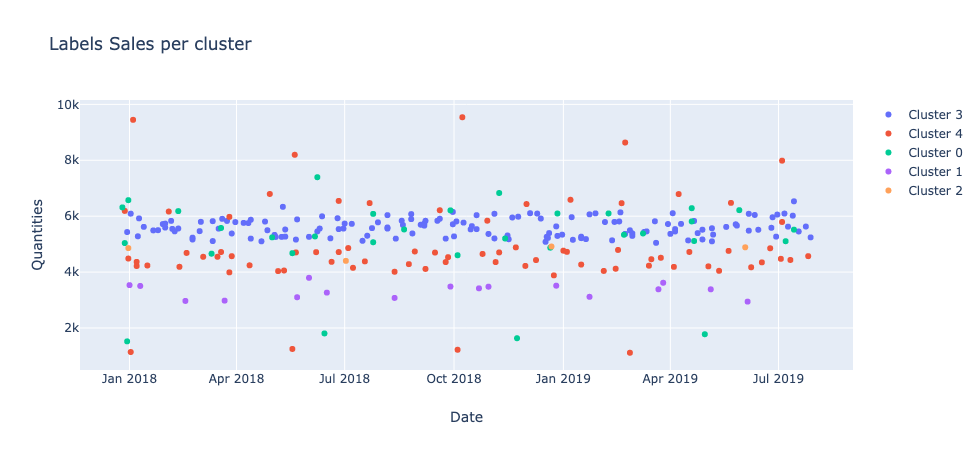

In [26]:
fig = go.Figure()

for cluster in sales_clusters_df.Cluster.value_counts().index.values:
    
    fig.add_trace(go.Scatter(x=sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_date'].astype(str).values,
                             y=sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_quantity'].values,
                        mode='markers',
                        name='Cluster '+str(cluster)))

# Edit the layout
fig.update_layout(title='Labels Sales per cluster',
                   xaxis_title='Date',
                   yaxis_title='Quantities')


fig.show()

In [27]:
cluster_0_products=sales_clusters_df[sales_clusters_df.Cluster==0].product_code.unique()

In [28]:
cluster_0_products

array(['CLA0', 'CLB1', 'CLC0', 'CLD3'], dtype=object)

In [29]:
for prod in cluster_0_products:
    print(prod)

CLA0
CLB1
CLC0
CLD3


In [30]:
cluster_0_preds=[]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


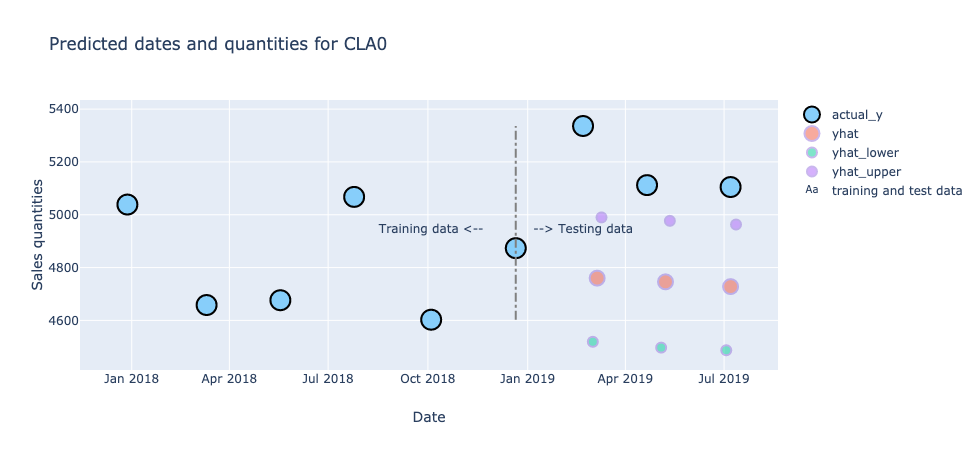

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


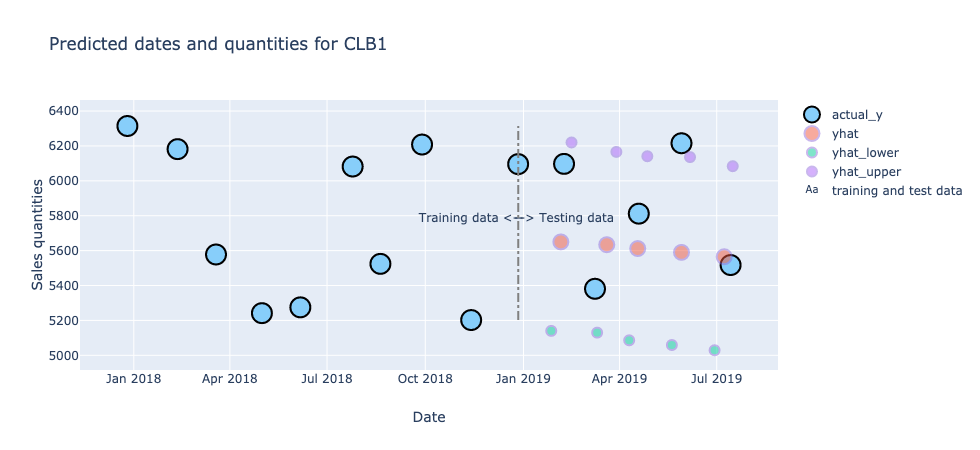

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 0.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


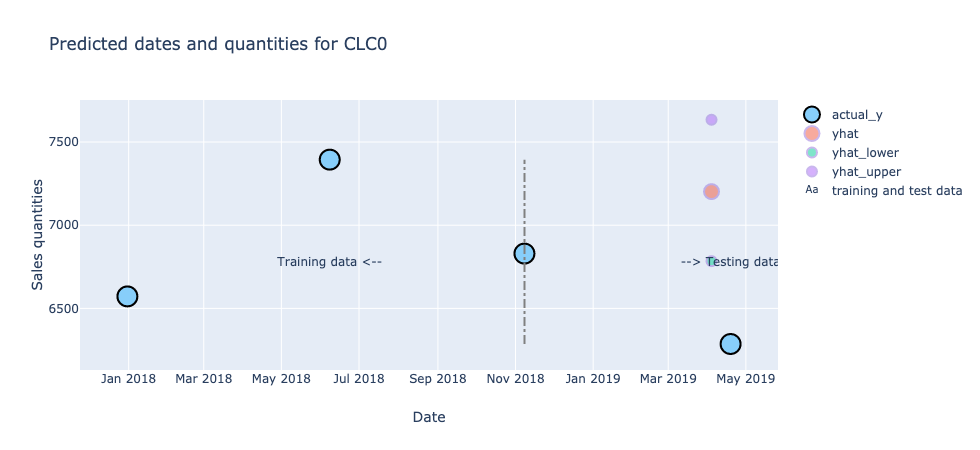

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 0.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


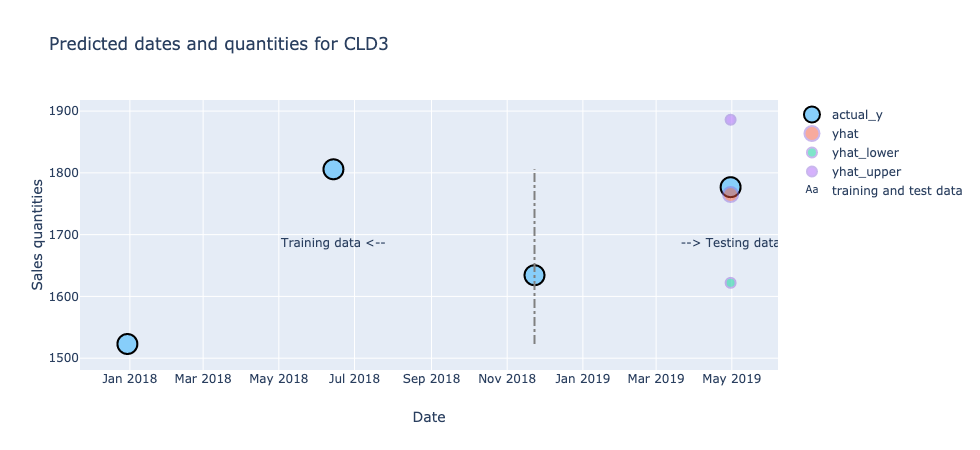

In [31]:
for prod in cluster_0_products:
    cluster_0_preds.append(generate_models_n_preds_df_n_plotly_viz(prod))

In [32]:
cluster_0_preds

[(<fbprophet.forecaster.Prophet at 0x1a1a4a0748>,
            ds     yhat_qty  yhat_lower_qty  yhat_upper_qty  yhat_date  \
  0 2017-12-28  4861.637512     4628.853170     5083.141790        NaT   
  1 2018-03-11  4844.114412     4619.123419     5086.533157 2018-03-06   
  2 2018-05-18  4827.791540     4611.868747     5058.960743 2018-05-20   
  3 2018-07-25  4811.468679     4577.015179     5032.430002 2018-07-28   
  4 2018-10-04  4794.425700     4567.090459     5043.031483 2018-10-05   
  5 2018-12-21  4775.702427     4539.973669     5009.049480 2018-12-17   
  6 2019-02-21  4760.819826     4519.004102     4990.220693 2019-03-06   
  7 2019-04-21  4746.657350     4497.967943     4977.831670 2019-05-08   
  8 2019-07-07  4728.174120     4487.683213     4963.368314 2019-07-07   
  
    yhat_lower_date yhat_upper_date            y  
  0             NaT             NaT  5038.619159  
  1      2018-03-02      2018-03-11  4658.195181  
  2      2018-05-16      2018-05-24  4676.433462  
  3

## Aggregate predictions and then plot them against actual data points

In [33]:
len(cluster_0_preds)

4

In [34]:
cluster_0_aggregated_preds=cluster_0_preds[0][2]
cluster_0_aggregated_preds['product']=cluster_0_products[0]
for i,prod in enumerate(cluster_0_products[1:]):
    print(i)
    print(prod)
    local_df=cluster_0_preds[i+1][2]
    local_df['product']=prod
    cluster_0_aggregated_preds=pd.concat([cluster_0_aggregated_preds,local_df])

0
CLB1
1
CLC0
2
CLD3


In [35]:
cluster_0_aggregated_preds

ds     yhat_qty  yhat_lower_qty  yhat_upper_qty  yhat_date  \
0  2017-12-28  4861.637512     4628.853170     5083.141790        NaT   
1  2018-03-11  4844.114412     4619.123419     5086.533157 2018-03-06   
2  2018-05-18  4827.791540     4611.868747     5058.960743 2018-05-20   
3  2018-07-25  4811.468679     4577.015179     5032.430002 2018-07-28   
4  2018-10-04  4794.425700     4567.090459     5043.031483 2018-10-05   
5  2018-12-21  4775.702427     4539.973669     5009.049480 2018-12-17   
6  2019-02-21  4760.819826     4519.004102     4990.220693 2019-03-06   
7  2019-04-21  4746.657350     4497.967943     4977.831670 2019-05-08   
8  2019-07-07  4728.174120     4487.683213     4963.368314 2019-07-07   
0  2017-12-26  5873.986619     5375.126856     6423.877965        NaT   
1  2018-02-11  5848.283814     5346.830907     6345.351762 2018-02-04   
2  2018-03-19  5828.596558     5285.156544     6332.845661 2018-03-23   
3  2018-05-01  5805.081223     5264.632347     6360.041521 2018-04-28   
4  2018-06-06  5785.393969     5254.651911     6298.511893 2018-06-10   
5  2018-07-25  5758.597435     5286.733837     6325.044716 2018-07-16   
6  2018-08-20  5744.378868     5211.247829     6278.247764 2018-09-03   
7  2018-09-28  5723.051015     5178.216835     6265.491829 2018-09-29   
8  2018-11-13  5697.895086     5143.883072     6254.046660 2018-11-07   
9  2018-12-27  5673.832893     5161.149381     6205.920279 2018-12-23   
10 2019-02-08  5650.317568     5140.148984     6220.676915 2019-02-05   
11 2019-03-09  5634.458395     5130.763159     6166.357192 2019-03-20   
12 2019-04-19  5612.036806     5086.574603     6141.867537 2019-04-18   
13 2019-05-29  5590.162086     5059.020471     6136.280755 2019-05-29   
14 2019-07-14  5565.006156     5029.969869     6084.739401 2019-07-08   
0  2017-12-31  6797.461846     6389.772638     7218.041132        NaT   
1  2018-06-08  6933.429828     6508.311042     7329.524620 2018-06-08   
2  2018-11-08  7064.266943     6654.905794     7472.739680 2018-11-08   
3  2019-04-19  7202.800358     6784.992244     7634.303171 2019-04-04   
0  2017-12-30  1597.380417     1460.426768     1733.722678        NaT   
1  2018-06-14  1654.760327     1514.112008     1797.754906 2018-06-14   
2  2018-11-23  1710.757589     1584.227272     1848.220970 2018-11-23   
3  2019-04-30  1765.372202     1622.218687     1886.950008 2019-04-30   

   yhat_lower_date yhat_upper_date            y product  
0              NaT             NaT  5038.619159    CLA0  
1       2018-03-02      2018-03-11  4658.195181    CLA0  
2       2018-05-16      2018-05-24  4676.433462    CLA0  
3       2018-07-24      2018-08-01  5067.550234    CLA0  
4       2018-10-01      2018-10-09  4602.628398    CLA0  
5       2018-12-12      2018-12-21  4873.462946    CLA0  
6       2019-03-02      2019-03-10  5336.037630    CLA0  
7       2019-05-04      2019-05-12  5112.239650    CLA0  
8       2019-07-03      2019-07-12  5104.938014    CLA0  
0              NaT             NaT  6314.400966    CLB1  
1       2018-01-27      2018-02-13  6181.772772    CLB1  
2       2018-03-15      2018-04-01  5577.890228    CLB1  
3       2018-04-19      2018-05-07  5241.655174    CLB1  
4       2018-06-01      2018-06-18  5274.909501    CLB1  
5       2018-07-07      2018-07-25  6082.095754    CLB1  
6       2018-08-25      2018-09-12  5524.199876    CLB1  
7       2018-09-21      2018-10-07  6208.139346    CLB1  
8       2018-10-29      2018-11-15  5202.157894    CLB1  
9       2018-12-15      2018-12-31  6095.953714    CLB1  
10      2019-01-27      2019-02-15  6097.284359    CLB1  
11      2019-03-11      2019-03-29  5381.317226    CLB1  
12      2019-04-10      2019-04-27  5811.909803    CLB1  
13      2019-05-20      2019-06-06  6215.565413    CLB1  
14      2019-06-29      2019-07-16  5517.380754    CLB1  
0              NaT             NaT  6572.009204    CLC0  
1       2018-06-08      2018-06-08  7394.180590    CLC0  
2       2018-11-08      2018-11-08 

In [36]:
cluster_0_aggregated_preds[cluster_0_aggregated_preds['yhat_date']>'2019-01-01']['yhat_date']

6    2019-03-06
7    2019-05-08
8    2019-07-07
10   2019-02-05
11   2019-03-20
12   2019-04-18
13   2019-05-29
14   2019-07-08
3    2019-04-04
3    2019-04-30
Name: yhat_date, dtype: datetime64[ns]

In [37]:
cluster_0_preds_test_year=cluster_0_aggregated_preds[cluster_0_aggregated_preds['yhat_date']>'2019-01-01']

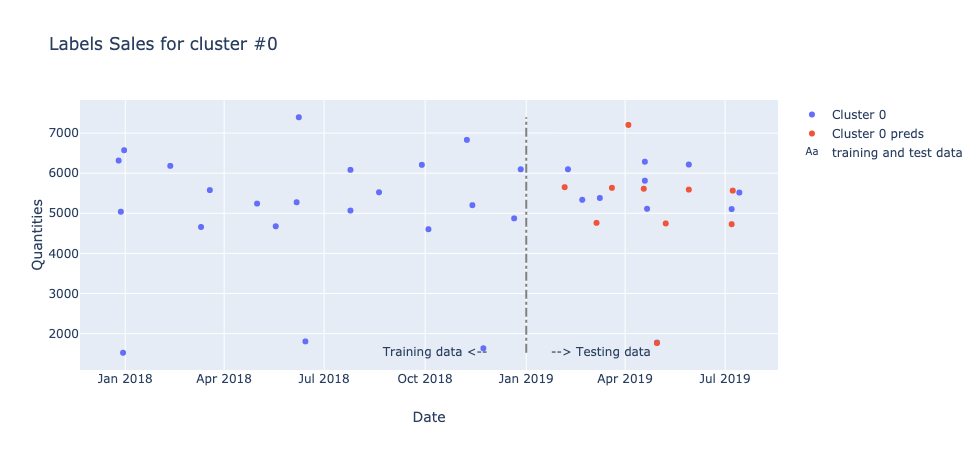

In [38]:
fig = go.Figure()

current_cluster=0
    
fig.add_trace(go.Scatter(x=sales_clusters_df[sales_clusters_df['Cluster']==current_cluster]['noisy_date'].astype(str).values,
                             y=sales_clusters_df[sales_clusters_df['Cluster']==current_cluster]['noisy_quantity'].values,
                        mode='markers',
                        name='Cluster '+str(current_cluster)))

fig.add_trace(go.Scatter(x=cluster_0_preds_test_year['yhat_date'].astype(str).values,
                             y=cluster_0_preds_test_year['yhat_qty'].values,
                        mode='markers',
                        name='Cluster '+str(current_cluster)+ ' preds'))

fig.update_layout(
        shapes=[
            # Line Vertical
            go.layout.Shape(
                type="line",
                x0='2019-01-01',
                y0=np.min(sales_clusters_df[sales_clusters_df['Cluster']==current_cluster]['noisy_quantity'].values),
                x1='2019-01-01',
                y1=np.max(sales_clusters_df[sales_clusters_df['Cluster']==current_cluster]['noisy_quantity'].values),
                line=dict(
                    color="grey",
                    width=2,
                    dash="dashdot"
                )
            )
        ]
    )

fig.add_trace(go.Scatter(
        x=['2018-10-10',
              '2019-03-10'],
        y=[np.min(sales_clusters_df[sales_clusters_df['Cluster']==current_cluster]['noisy_quantity'].values),
                   np.min(sales_clusters_df[sales_clusters_df['Cluster']==current_cluster]['noisy_quantity'].values)],
        text=["Training data <--",
              "--> Testing data"],
        mode="text",
        name='training and test data'
    ))

# Edit the layout
fig.update_layout(title='Labels Sales for cluster #' + str(current_cluster),
                   xaxis_title='Date',
                   yaxis_title='Quantities')


fig.show()

## Transform this into a function:
-  Input: 
  -  Cluster
  -  Test year
  -  sales_cluster_df
-  Output:
  -  Sales_aggregated_preds_df
  -  Plotly graph

In [44]:
def get_aggregated_preds(sales_clusters_df,cluster,test_start_date):
    
    cluster_products=sales_clusters_df[sales_clusters_df.Cluster==cluster].product_code.unique()
    
    cluster_preds=[]
    for prod in cluster_products:
        cluster_preds.append(generate_models_n_preds_df_n_plotly_viz(prod))
        
    cluster_aggregated_preds=cluster_preds[0][2]
    cluster_aggregated_preds['product']=cluster_products[0]
    for i,prod in enumerate(cluster_products[1:]):
        print(i)
        print(prod)
        local_df=cluster_preds[i+1][2]
        local_df['product']=prod
        cluster_aggregated_preds=pd.concat([cluster_aggregated_preds,local_df])
        
    cluster_preds_test_year=cluster_aggregated_preds[cluster_aggregated_preds['yhat_date']>test_start_date]
    

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_date'].astype(str).values,
                                 y=sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_quantity'].values,
                            mode='markers',
                            name='Cluster '+str(cluster)))

    fig.add_trace(go.Scatter(x=cluster_preds_test_year['yhat_date'].astype(str).values,
                                 y=cluster_preds_test_year['yhat_qty'].values,
                            mode='markers',
                            name='Cluster '+str(cluster)+ ' preds'))

    fig.update_layout(
            shapes=[
                # Line Vertical
                go.layout.Shape(
                    type="line",
                    x0=test_start_date,
                    y0=np.min(sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_quantity'].values),
                    x1=test_start_date,
                    y1=np.max(sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_quantity'].values),
                    line=dict(
                        color="grey",
                        width=2,
                        dash="dashdot"
                    )
                )
            ]
        )

    fig.add_trace(go.Scatter(
            x=[str(int(test_start_date.split('-')[0])-1)+'-10-10',
                  test_start_date.split('-')[0]+'-03-10'],
            y=[np.min(sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_quantity'].values),
                       np.min(sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_quantity'].values)],
            text=["Training data <--",
                  "--> Testing data"],
            mode="text",
            name='training and test data'
        ))

    # Edit the layout
    fig.update_layout(title='Labels Sales for cluster #' + str(cluster),
                       xaxis_title='Date',
                       yaxis_title='Quantities')


    fig.show()
    
    return cluster_aggregated_preds

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


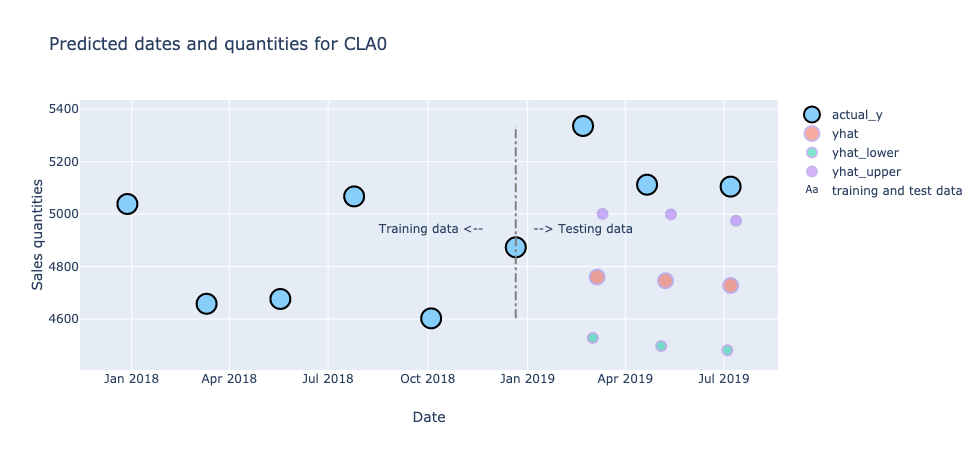

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


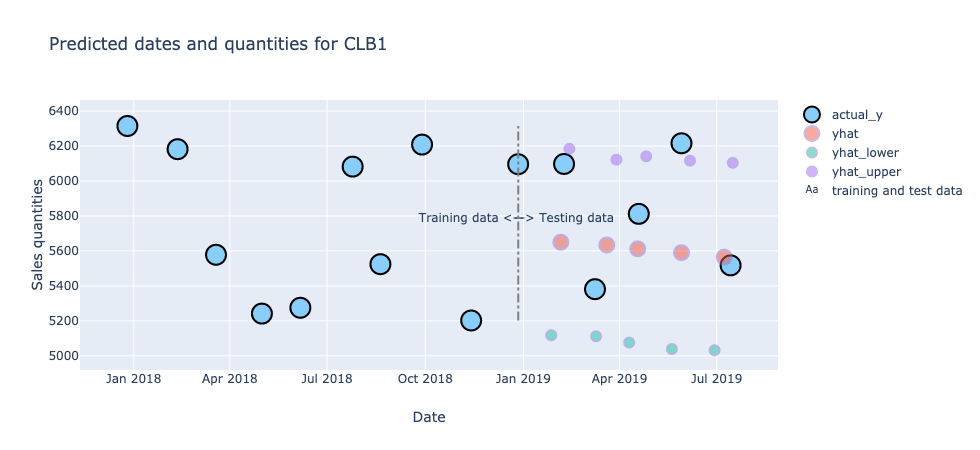

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 0.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


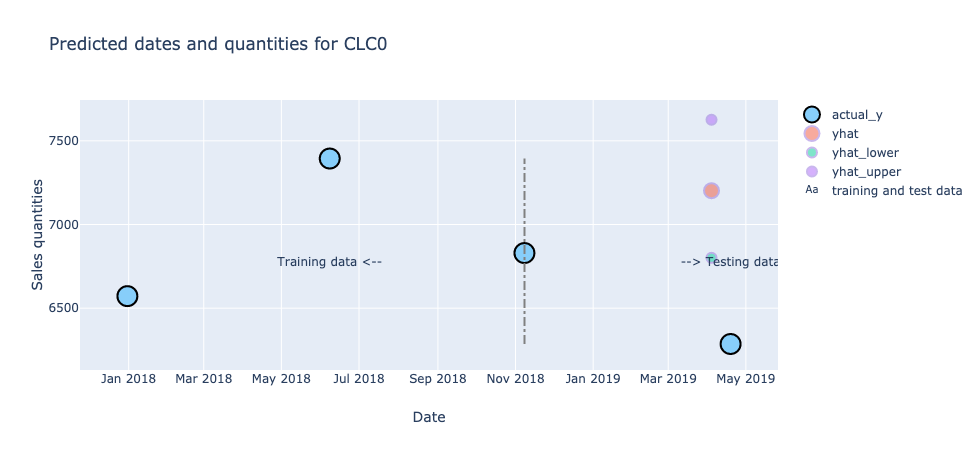

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 0.


---------------------------------
--> Now training the "date model"
---------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.


-------------------------------------
--> Now training the "quantity model"
-------------------------------------


0
CLB1
1
CLC0
2
CLD3


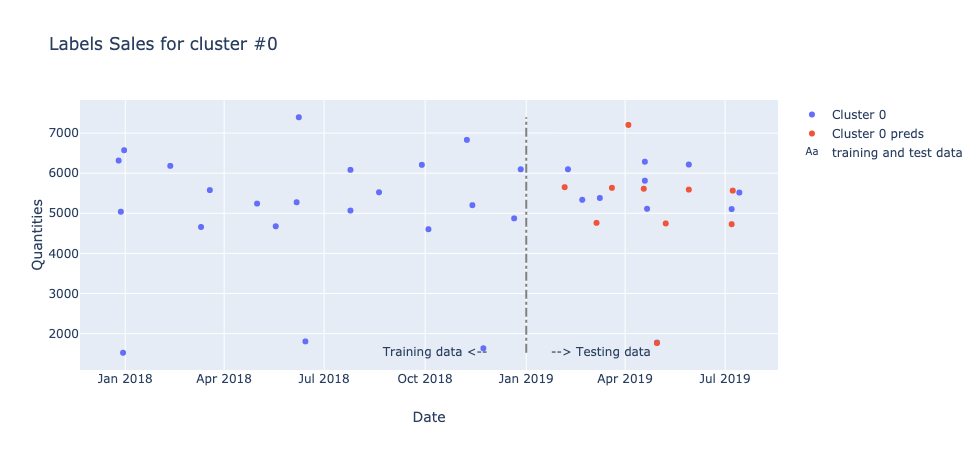

In [45]:
cluster_0_aggregated_preds=get_aggregated_preds(sales_clusters_df,0,'2019-01-01')

# Cluster #0 predictions

In [ ]:
cluster_prophet_df=sales_clusters_df[sales_clusters_df['Cluster']==0][['noisy_date','noisy_quantity']].copy()

In [ ]:
cluster_prophet_df.rename(index=str, columns={"noisy_date": "ds",
                                      "noisy_quantity": "y"},
                 inplace=True)

In [ ]:
cluster_prophet_df.describe()

In [ ]:
cluster_prophet_df=cluster_prophet_df.sort_values('ds')
cluster_prophet_df['cap'] = 8000
cluster_prophet_df['floor'] = 1300

In [ ]:
cluster_model=Prophet(growth='logistic',
                      changepoint_prior_scale= 0.001)

In [ ]:
cluster_model.fit(cluster_prophet_df[:25])

In [ ]:
cluster_prophet_df.info()

In [ ]:
cluster_forecast = cluster_model.predict(pd.DataFrame(cluster_prophet_df[['ds','cap','floor']]))

In [ ]:
cluster_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
cluster_prophet_df.tail()

In [ ]:
cluster_prophet_df[:25]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig1 = cluster_model.plot(cluster_forecast)
plt.scatter(cluster_prophet_df['ds'],
           cluster_prophet_df['y'],color='g')